In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import random
import tifffile as tiff
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
df = pd.read_csv("/kaggle/input/cloud-masking-mislabled-flags/23_4_mislabeled_flags.csv")
mislabeled_dict = dict(zip(df["filename"], df["mislabeled"]))

In [3]:
root = "/kaggle/input/cloud-masking-dataset/content/train"
image_dir = os.path.join(root, "data")
mask_dir = os.path.join(root, "masks")
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) 
                      if f.endswith('.tif') and mislabeled_dict[f]=="no"])
mask_files = sorted([os.path.join(mask_dir, f)] for f in os.listdir(mask_dir) 
                    if f.endswith('.tif') and mislabeled_dict[f]=="no")
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.1, random_state=42
)

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)        # (B, 64, H, W)
        x2 = self.down2(F.max_pool2d(x1, 2))  # (B, 128, H/2, W/2)
        x3 = self.down3(F.max_pool2d(x2, 2))  # (B, 256, H/4, W/4)
        x4 = self.down4(F.max_pool2d(x3, 2))  # (B, 512, H/8, W/8)
        x5 = self.bottleneck(F.max_pool2d(x4, 2))  # (B, 1024, H/16, W/16)

        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))
        return self.final(x)


In [5]:
def normalize_img(img):
    img = img.astype('float32')
    normalize_band = lambda band: (band - band.min()) / (band.max() - band.min() + 1e-6)
    for i in range(img.shape[2]):
        img[..., i] = normalize_band(img[..., i])
    return img

In [6]:
class CloudDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        mask_file = self.mask_files[idx]

        image = tiff.imread(image_file)
        mask = tiff.imread(mask_file)

        image = normalize_img(image)
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

In [7]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),                       
    A.VerticalFlip(p=0.5),                         
    A.RandomRotate90(p=0.5),                       

    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, 
                       rotate_limit=15, p=0.5),    

    A.OneOf([                                       
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.03, p=0.3),
        A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3),
    ], p=0.3),                                     

    A.GaussianBlur(blur_limit=(3, 5), p=0.2),      
    A.RandomBrightnessContrast(p=0.3),             
    ToTensorV2()
])

val_transform = A.Compose([
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/4106432380.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.3),
/tmp/ipykernel_19/4106432380.py:12: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3),


img shape:  torch.Size([4, 512, 512])
mask shape:  torch.Size([512, 512])
0.0 1.0
0 1


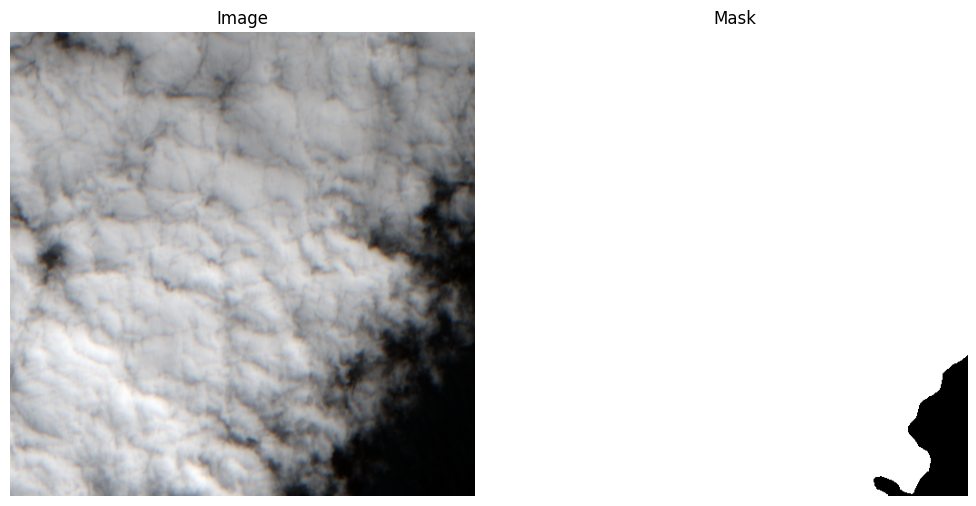

img shape:  torch.Size([4, 512, 512])
mask shape:  torch.Size([512, 512])
0.0 1.0
0 1


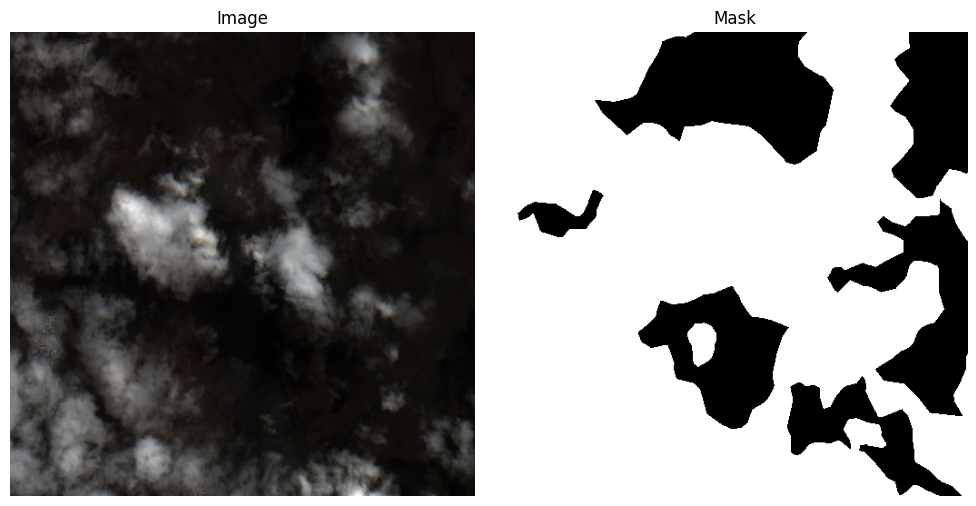

img shape:  torch.Size([4, 512, 512])
mask shape:  torch.Size([512, 512])
0.0 1.0
0 1


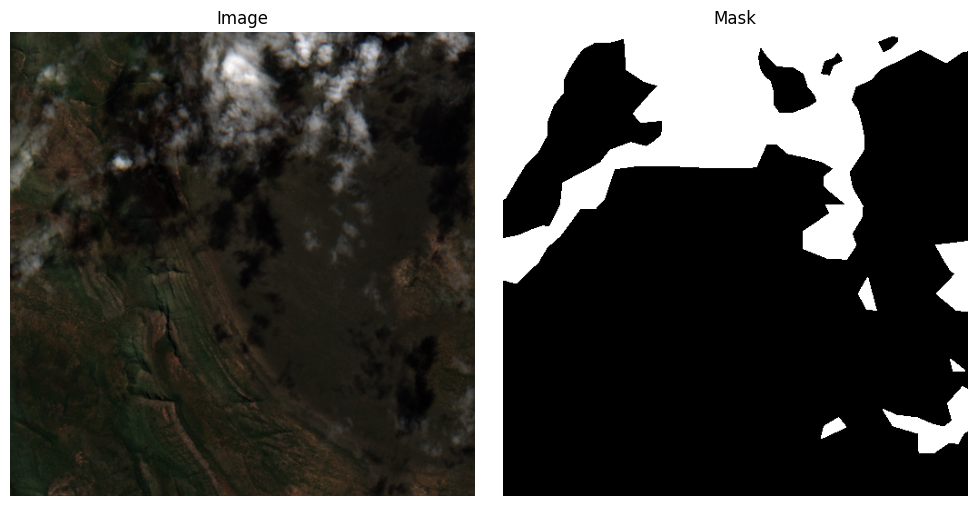

img shape:  torch.Size([4, 512, 512])
mask shape:  torch.Size([512, 512])
0.0 1.0
0 1


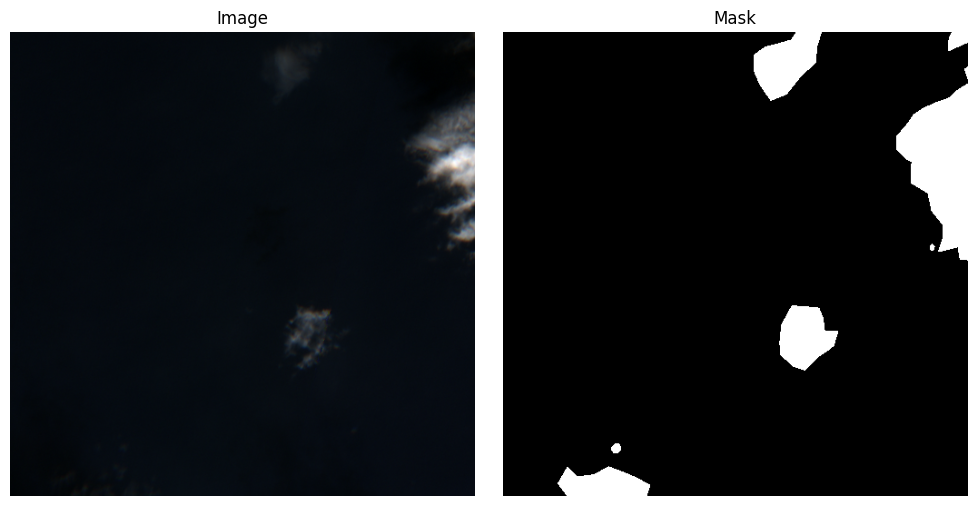

img shape:  torch.Size([4, 512, 512])
mask shape:  torch.Size([512, 512])
0.0 1.0
0 1


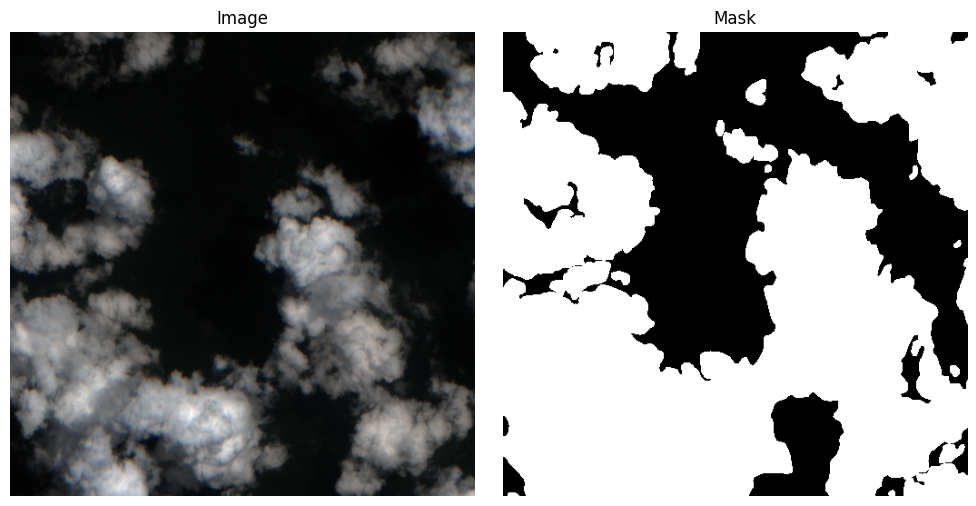

img shape:  torch.Size([4, 512, 512])
mask shape:  torch.Size([512, 512])
0.0 1.0
0 1


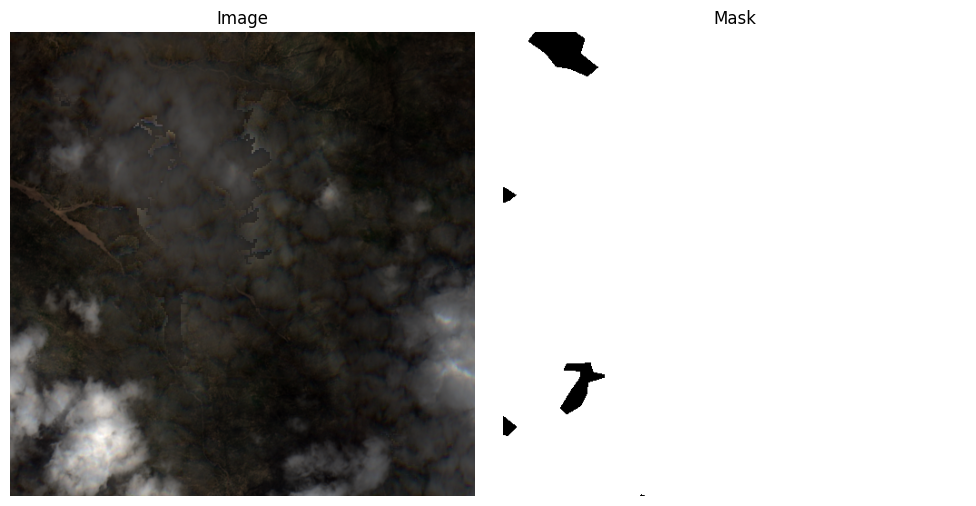

img shape:  torch.Size([4, 512, 512])
mask shape:  torch.Size([512, 512])
0.0 1.0
0 1


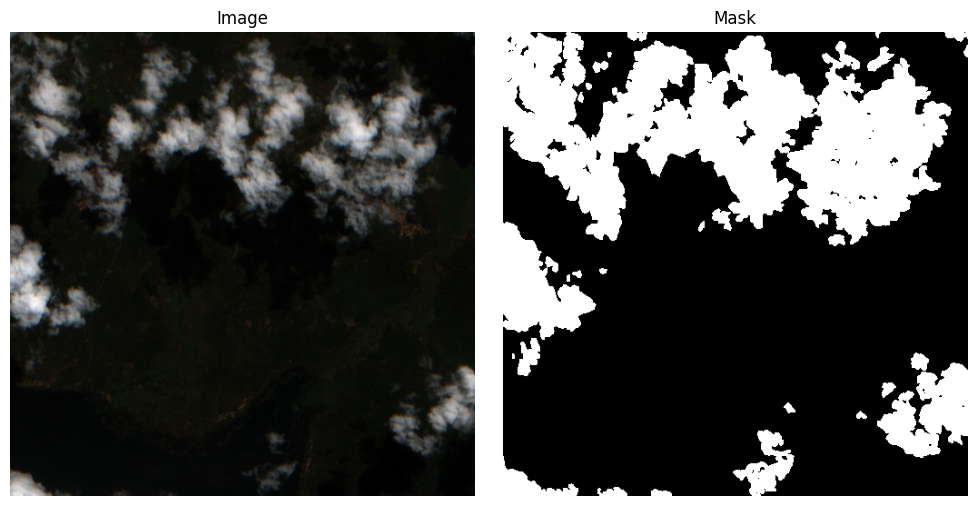

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_sample(dataset, idx=None, rgb_indices=(2, 1, 0)):  # Default: BGR -> RGB
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
        
    image, mask = dataset[idx]  # image: Tensor (C, H, W), mask: Tensor (H, W)
    print("img shape: ", image.shape)
    print("mask shape: ", mask.shape)
    image_np = image.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    mask_np = mask.cpu().numpy()
    print(image_np.min(), image_np.max())
    print(mask_np.min(), mask_np.max())

    # Normalize for RGB display
    if image_np.shape[-1] >= 3:
        rgb = image_np[..., list(rgb_indices)]
        rgb = np.clip(rgb, 0, 1)
    else:
        rgb = image_np[..., 0]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(rgb)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask_np, cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Uncomment for visualizations
for _ in range(7):
    visualize_sample(CloudDataset(val_imgs, val_masks, val_transform))

In [9]:
batch_size = 8

train_dataset = CloudDataset(train_imgs, train_masks, train_transform)
val_dataset = CloudDataset(val_imgs, val_masks, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
def compute_iou(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds) > threshold  # convert logits to binary mask
    preds = preds.int()
    targets = targets.int()

    intersection = (preds & targets).float().sum((1, 2, 3))
    union = (preds | targets).float().sum((1, 2, 3))

    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()  # mIoU over batch


In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # Ensure preds are in [0, 1]
        preds = preds.view(-1)
        targets = targets.view(-1)

        intersection = (preds * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

        return 1 - dice_score

In [12]:
def visualize_predictions(model, dataloader, device, num_samples=3, threshold=0.5):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device).unsqueeze(1).float()

    with torch.no_grad():
        preds = torch.sigmoid(model(images))
        preds = (preds > threshold).float()

    for i in range(min(num_samples, images.size(0))):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        mask_true = masks[i, 0].cpu().numpy()
        mask_pred = preds[i, 0].cpu().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(np.clip(img, 0, 1))
        axs[0].set_title("Image")
        axs[1].imshow(mask_true, cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(mask_pred, cmap='gray')
        axs[2].set_title("Prediction")
        for ax in axs: ax.axis('off')
        plt.tight_layout()
        plt.show()


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = UNet(in_channels=4, out_channels=1).to(device)
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

cuda


100%|██████████| 93/93 [00:59<00:00,  1.55it/s]


Epoch 1 | Learning rate: 0.001000
Epoch [1/45], Train Loss: 0.3286, Val Loss: 0.7334, Val Bloss: 0.9296, Val Dloss: 0.5372, Val mIoU: 0.2719
Best model saved at epoch 1


100%|██████████| 93/93 [00:39<00:00,  2.38it/s]


Epoch 2 | Learning rate: 0.001000
Epoch [2/45], Train Loss: 0.2676, Val Loss: 0.3739, Val Bloss: 0.4639, Val Dloss: 0.2839, Val mIoU: 0.5333
Best model saved at epoch 2


100%|██████████| 93/93 [00:38<00:00,  2.39it/s]


Epoch 3 | Learning rate: 0.001000
Epoch [3/45], Train Loss: 0.2375, Val Loss: 0.2076, Val Bloss: 0.2697, Val Dloss: 0.1454, Val mIoU: 0.7024
Best model saved at epoch 3


100%|██████████| 93/93 [00:38<00:00,  2.39it/s]


Epoch 4 | Learning rate: 0.001000
Epoch [4/45], Train Loss: 0.2250, Val Loss: 0.3666, Val Bloss: 0.4463, Val Dloss: 0.2870, Val mIoU: 0.5659


100%|██████████| 93/93 [00:38<00:00,  2.40it/s]


Epoch 5 | Learning rate: 0.001000
Epoch [5/45], Train Loss: 0.2079, Val Loss: 0.1753, Val Bloss: 0.2290, Val Dloss: 0.1217, Val mIoU: 0.7457
Best model saved at epoch 5


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 6 | Learning rate: 0.001000
Epoch [6/45], Train Loss: 0.2005, Val Loss: 0.1645, Val Bloss: 0.2215, Val Dloss: 0.1074, Val mIoU: 0.7549
Best model saved at epoch 6


100%|██████████| 93/93 [00:39<00:00,  2.35it/s]


Epoch 7 | Learning rate: 0.001000
Epoch [7/45], Train Loss: 0.1917, Val Loss: 0.1766, Val Bloss: 0.2275, Val Dloss: 0.1256, Val mIoU: 0.7285


100%|██████████| 93/93 [00:38<00:00,  2.41it/s]


Epoch 8 | Learning rate: 0.001000
Epoch [8/45], Train Loss: 0.1857, Val Loss: 0.1946, Val Bloss: 0.2511, Val Dloss: 0.1380, Val mIoU: 0.7507


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 9 | Learning rate: 0.001000
Epoch [9/45], Train Loss: 0.1835, Val Loss: 0.2140, Val Bloss: 0.2780, Val Dloss: 0.1499, Val mIoU: 0.7151


100%|██████████| 93/93 [00:38<00:00,  2.39it/s]


Epoch 10 | Learning rate: 0.001000
Epoch [10/45], Train Loss: 0.1799, Val Loss: 0.1553, Val Bloss: 0.1933, Val Dloss: 0.1173, Val mIoU: 0.7520


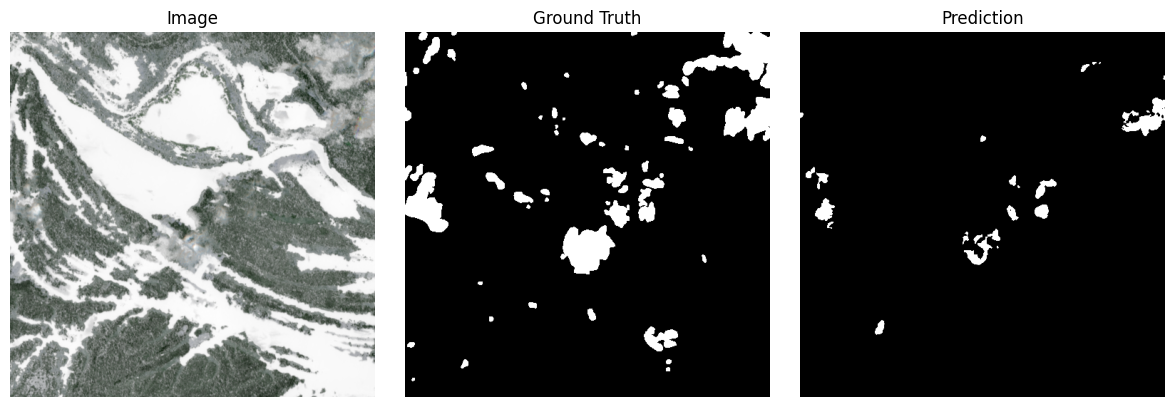

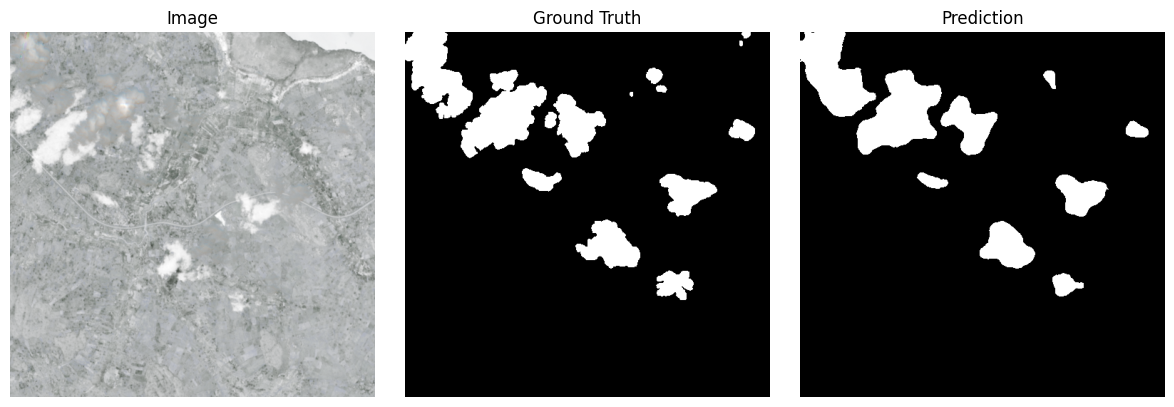

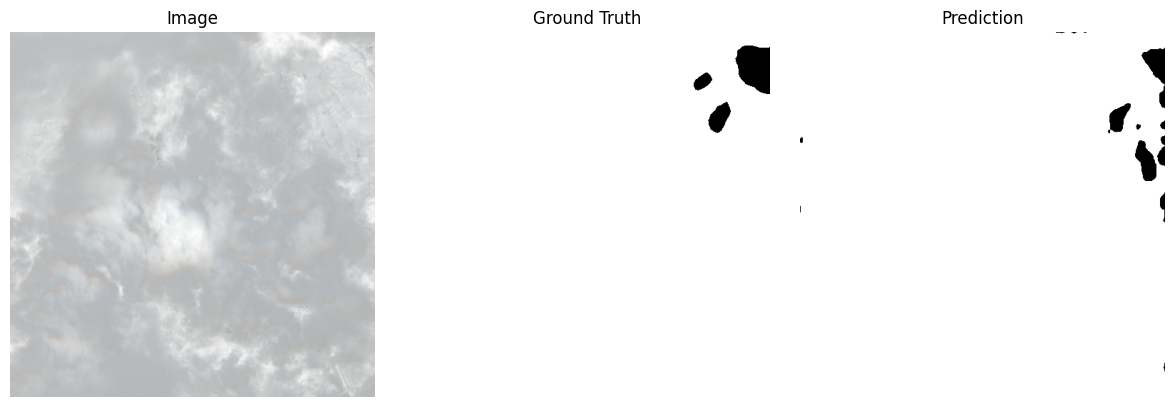

Best model saved at epoch 10


100%|██████████| 93/93 [00:38<00:00,  2.39it/s]


Epoch 11 | Learning rate: 0.001000
Epoch [11/45], Train Loss: 0.1788, Val Loss: 0.1582, Val Bloss: 0.1976, Val Dloss: 0.1189, Val mIoU: 0.7650


100%|██████████| 93/93 [00:39<00:00,  2.38it/s]


Epoch 12 | Learning rate: 0.001000
Epoch [12/45], Train Loss: 0.1726, Val Loss: 0.1781, Val Bloss: 0.2167, Val Dloss: 0.1395, Val mIoU: 0.7417


100%|██████████| 93/93 [00:39<00:00,  2.37it/s]


Epoch 13 | Learning rate: 0.001000
Epoch [13/45], Train Loss: 0.1652, Val Loss: 0.1524, Val Bloss: 0.1939, Val Dloss: 0.1108, Val mIoU: 0.7738
Best model saved at epoch 13


100%|██████████| 93/93 [00:39<00:00,  2.37it/s]


Epoch 14 | Learning rate: 0.001000
Epoch [14/45], Train Loss: 0.1637, Val Loss: 0.1577, Val Bloss: 0.2020, Val Dloss: 0.1134, Val mIoU: 0.7792


100%|██████████| 93/93 [00:39<00:00,  2.36it/s]


Epoch 15 | Learning rate: 0.001000
Epoch [15/45], Train Loss: 0.1637, Val Loss: 0.1813, Val Bloss: 0.2196, Val Dloss: 0.1430, Val mIoU: 0.7504


100%|██████████| 93/93 [00:39<00:00,  2.38it/s]


Epoch 16 | Learning rate: 0.001000
Epoch [16/45], Train Loss: 0.1598, Val Loss: 0.1377, Val Bloss: 0.1805, Val Dloss: 0.0948, Val mIoU: 0.7857
Best model saved at epoch 16


100%|██████████| 93/93 [00:39<00:00,  2.36it/s]


Epoch 17 | Learning rate: 0.001000
Epoch [17/45], Train Loss: 0.1595, Val Loss: 0.1795, Val Bloss: 0.2298, Val Dloss: 0.1292, Val mIoU: 0.7660


100%|██████████| 93/93 [00:38<00:00,  2.40it/s]


Epoch 18 | Learning rate: 0.001000
Epoch [18/45], Train Loss: 0.1561, Val Loss: 0.1467, Val Bloss: 0.1791, Val Dloss: 0.1144, Val mIoU: 0.7862


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 19 | Learning rate: 0.001000
Epoch [19/45], Train Loss: 0.1556, Val Loss: 0.1456, Val Bloss: 0.1821, Val Dloss: 0.1091, Val mIoU: 0.7924


100%|██████████| 93/93 [00:38<00:00,  2.41it/s]


Epoch 20 | Learning rate: 0.000500
Epoch [20/45], Train Loss: 0.1521, Val Loss: 0.1431, Val Bloss: 0.1715, Val Dloss: 0.1147, Val mIoU: 0.7710


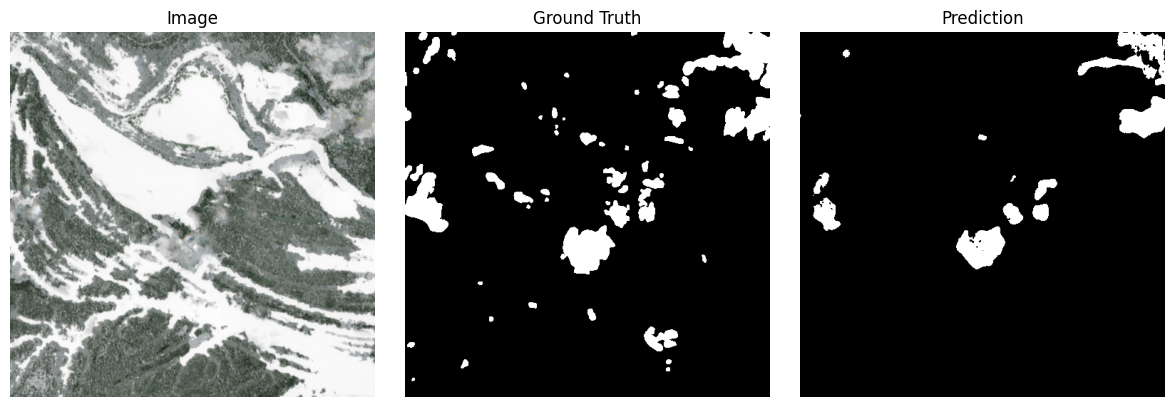

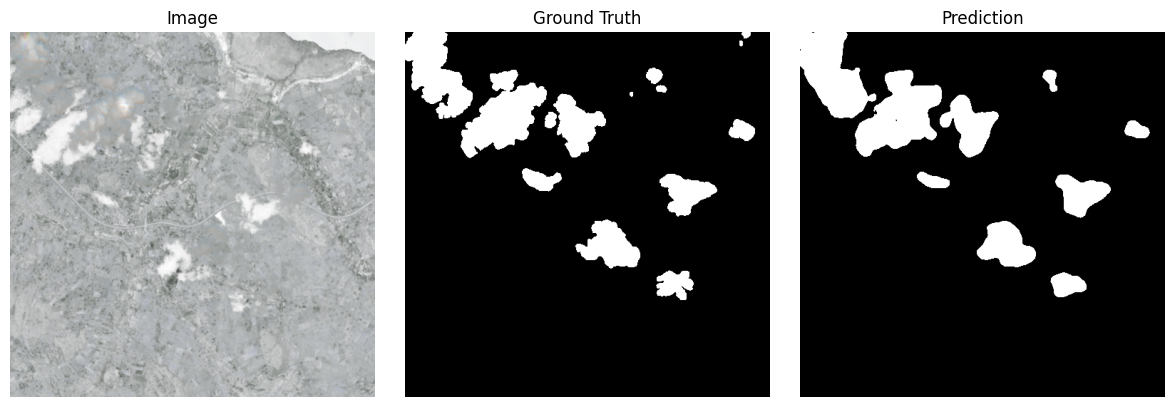

100%|██████████| 93/93 [00:37<00:00,  2.45it/s]


Epoch 21 | Learning rate: 0.000500
Epoch [21/45], Train Loss: 0.1448, Val Loss: 0.1436, Val Bloss: 0.1837, Val Dloss: 0.1035, Val mIoU: 0.7846


100%|██████████| 93/93 [00:37<00:00,  2.45it/s]


Epoch 22 | Learning rate: 0.000500
Epoch [22/45], Train Loss: 0.1420, Val Loss: 0.1293, Val Bloss: 0.1628, Val Dloss: 0.0958, Val mIoU: 0.8125
Best model saved at epoch 22


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 23 | Learning rate: 0.000500
Epoch [23/45], Train Loss: 0.1414, Val Loss: 0.1302, Val Bloss: 0.1648, Val Dloss: 0.0956, Val mIoU: 0.8002


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 24 | Learning rate: 0.000500
Epoch [24/45], Train Loss: 0.1427, Val Loss: 0.1262, Val Bloss: 0.1601, Val Dloss: 0.0922, Val mIoU: 0.8046
Best model saved at epoch 24


100%|██████████| 93/93 [00:39<00:00,  2.37it/s]


Epoch 25 | Learning rate: 0.000500
Epoch [25/45], Train Loss: 0.1393, Val Loss: 0.1255, Val Bloss: 0.1661, Val Dloss: 0.0850, Val mIoU: 0.8096
Best model saved at epoch 25


100%|██████████| 93/93 [00:39<00:00,  2.38it/s]


Epoch 26 | Learning rate: 0.000500
Epoch [26/45], Train Loss: 0.1394, Val Loss: 0.1654, Val Bloss: 0.1879, Val Dloss: 0.1428, Val mIoU: 0.7779


100%|██████████| 93/93 [00:38<00:00,  2.40it/s]


Epoch 27 | Learning rate: 0.000500
Epoch [27/45], Train Loss: 0.1379, Val Loss: 0.1294, Val Bloss: 0.1618, Val Dloss: 0.0970, Val mIoU: 0.8063


100%|██████████| 93/93 [00:38<00:00,  2.41it/s]


Epoch 28 | Learning rate: 0.000500
Epoch [28/45], Train Loss: 0.1363, Val Loss: 0.1470, Val Bloss: 0.1776, Val Dloss: 0.1165, Val mIoU: 0.7832


100%|██████████| 93/93 [00:38<00:00,  2.40it/s]


Epoch 29 | Learning rate: 0.000250
Epoch [29/45], Train Loss: 0.1375, Val Loss: 0.1349, Val Bloss: 0.1701, Val Dloss: 0.0997, Val mIoU: 0.8081


100%|██████████| 93/93 [00:37<00:00,  2.47it/s]


Epoch 30 | Learning rate: 0.000250
Epoch [30/45], Train Loss: 0.1334, Val Loss: 0.1243, Val Bloss: 0.1570, Val Dloss: 0.0915, Val mIoU: 0.8071


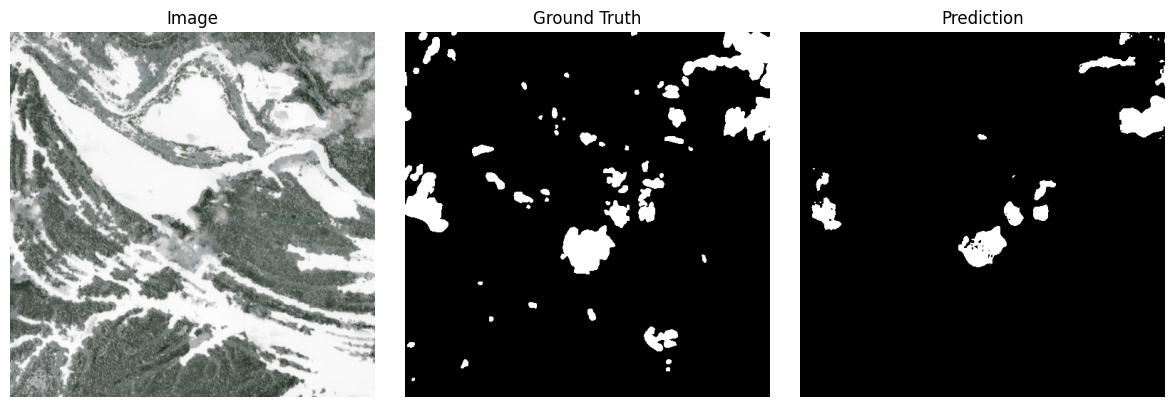

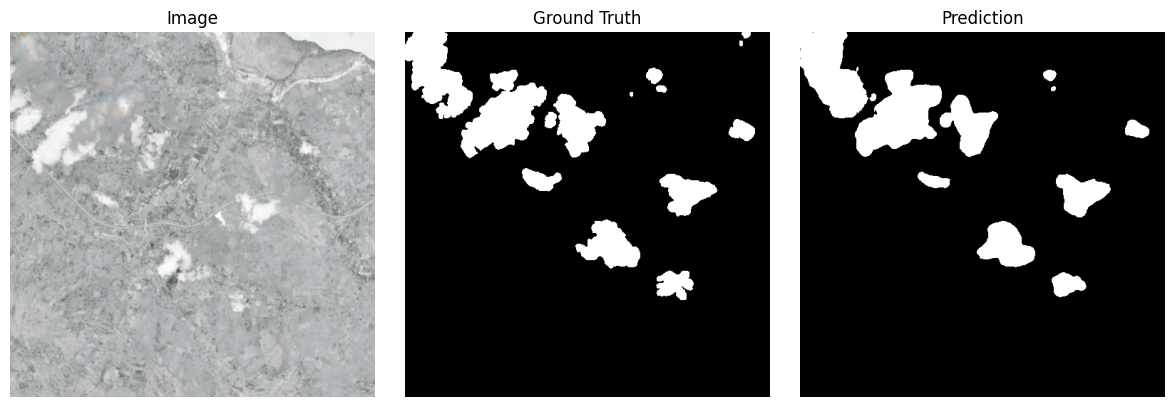

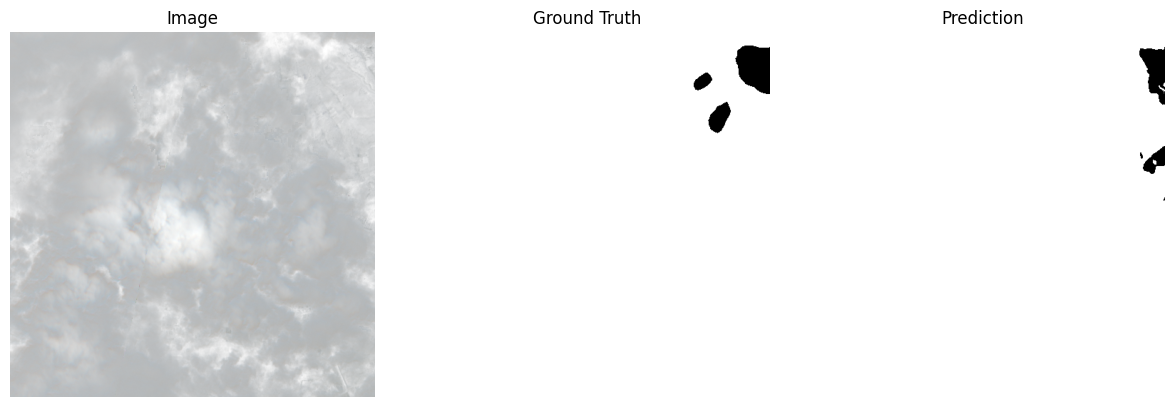

Best model saved at epoch 30


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 31 | Learning rate: 0.000250
Epoch [31/45], Train Loss: 0.1317, Val Loss: 0.1236, Val Bloss: 0.1586, Val Dloss: 0.0886, Val mIoU: 0.7929
Best model saved at epoch 31


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 32 | Learning rate: 0.000250
Epoch [32/45], Train Loss: 0.1322, Val Loss: 0.1309, Val Bloss: 0.1602, Val Dloss: 0.1016, Val mIoU: 0.8013


100%|██████████| 93/93 [00:38<00:00,  2.43it/s]


Epoch 33 | Learning rate: 0.000250
Epoch [33/45], Train Loss: 0.1320, Val Loss: 0.1250, Val Bloss: 0.1561, Val Dloss: 0.0939, Val mIoU: 0.8100


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 34 | Learning rate: 0.000250
Epoch [34/45], Train Loss: 0.1296, Val Loss: 0.1236, Val Bloss: 0.1575, Val Dloss: 0.0897, Val mIoU: 0.8207
Best model saved at epoch 34


100%|██████████| 93/93 [00:37<00:00,  2.46it/s]


Epoch 35 | Learning rate: 0.000250
Epoch [35/45], Train Loss: 0.1285, Val Loss: 0.1295, Val Bloss: 0.1604, Val Dloss: 0.0986, Val mIoU: 0.7987


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 36 | Learning rate: 0.000250
Epoch [36/45], Train Loss: 0.1300, Val Loss: 0.1241, Val Bloss: 0.1559, Val Dloss: 0.0922, Val mIoU: 0.8101


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 37 | Learning rate: 0.000250
Epoch [37/45], Train Loss: 0.1306, Val Loss: 0.1557, Val Bloss: 0.1816, Val Dloss: 0.1298, Val mIoU: 0.7930


100%|██████████| 93/93 [00:38<00:00,  2.39it/s]


Epoch 38 | Learning rate: 0.000125
Epoch [38/45], Train Loss: 0.1287, Val Loss: 0.1295, Val Bloss: 0.1592, Val Dloss: 0.0998, Val mIoU: 0.8117


100%|██████████| 93/93 [00:38<00:00,  2.41it/s]


Epoch 39 | Learning rate: 0.000125
Epoch [39/45], Train Loss: 0.1280, Val Loss: 0.1242, Val Bloss: 0.1545, Val Dloss: 0.0939, Val mIoU: 0.8041


100%|██████████| 93/93 [00:38<00:00,  2.42it/s]


Epoch 40 | Learning rate: 0.000125
Epoch [40/45], Train Loss: 0.1264, Val Loss: 0.1245, Val Bloss: 0.1534, Val Dloss: 0.0956, Val mIoU: 0.8162


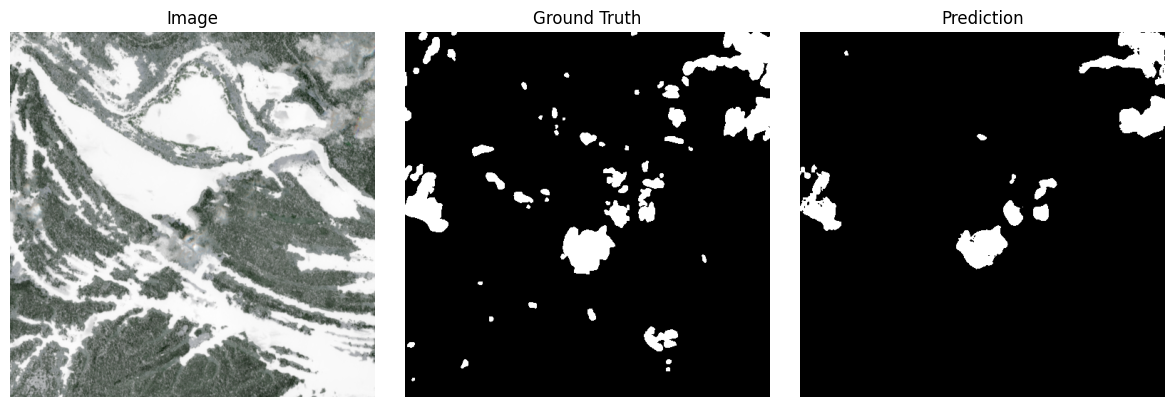

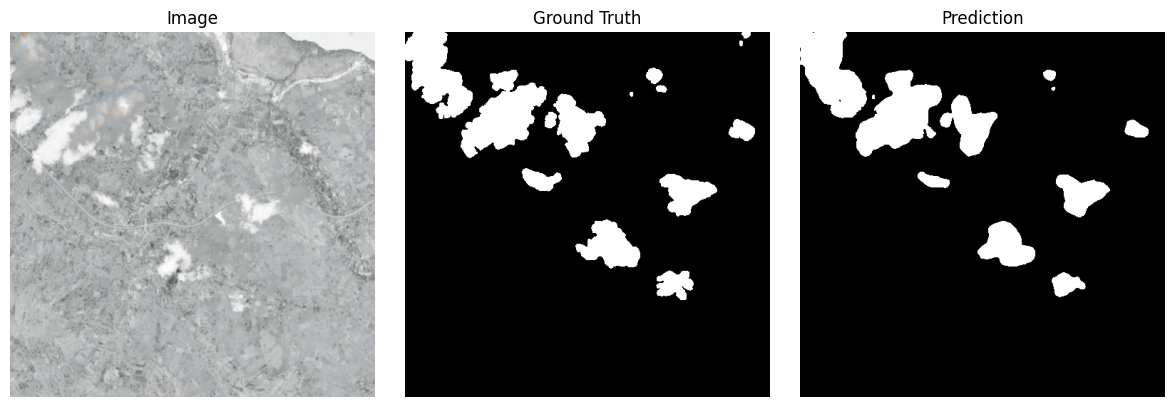

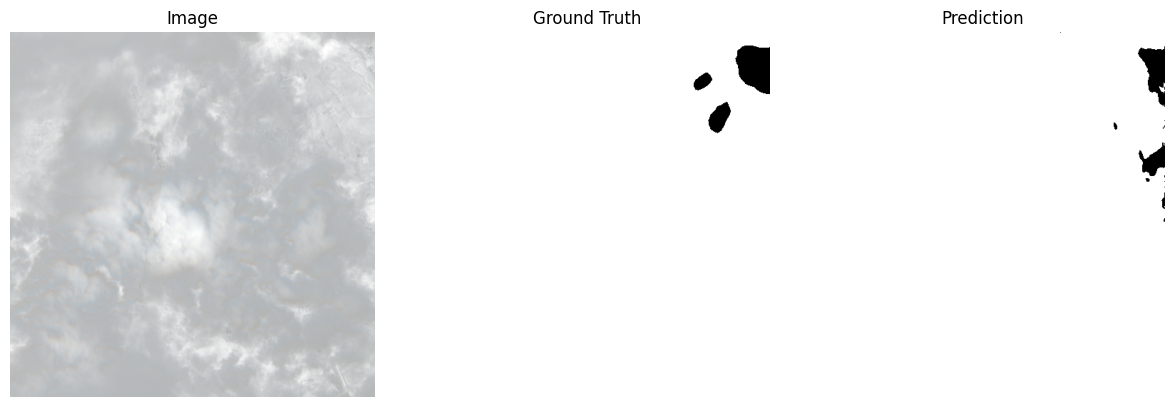

100%|██████████| 93/93 [00:38<00:00,  2.41it/s]


Epoch 41 | Learning rate: 0.000125
Epoch [41/45], Train Loss: 0.1276, Val Loss: 0.1203, Val Bloss: 0.1532, Val Dloss: 0.0874, Val mIoU: 0.8199
Best model saved at epoch 41


100%|██████████| 93/93 [00:38<00:00,  2.41it/s]


Epoch 42 | Learning rate: 0.000125
Epoch [42/45], Train Loss: 0.1283, Val Loss: 0.1204, Val Bloss: 0.1510, Val Dloss: 0.0898, Val mIoU: 0.8119


100%|██████████| 93/93 [00:38<00:00,  2.40it/s]


Epoch 43 | Learning rate: 0.000125
Epoch [43/45], Train Loss: 0.1271, Val Loss: 0.1207, Val Bloss: 0.1498, Val Dloss: 0.0917, Val mIoU: 0.7995


100%|██████████| 93/93 [00:38<00:00,  2.41it/s]


Epoch 44 | Learning rate: 0.000125
Epoch [44/45], Train Loss: 0.1275, Val Loss: 0.1235, Val Bloss: 0.1556, Val Dloss: 0.0915, Val mIoU: 0.8108


100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Epoch 45 | Learning rate: 0.000063
Epoch [45/45], Train Loss: 0.1259, Val Loss: 0.1253, Val Bloss: 0.1569, Val Dloss: 0.0937, Val mIoU: 0.8195


In [14]:
from tqdm import tqdm

num_epochs = 45
best_loss = float('inf')
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = 0.5 * bce_loss(outputs, masks) + 0.5 * dice_loss(outputs, masks)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    val_mIoU = 0.0
    with torch.no_grad():
        val_loss = 0.0
        val_bloss = 0.0
        val_dloss = 0.0
        for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()
            outputs = model(images)
            bloss = bce_loss(outputs, masks)
            dloss = dice_loss(outputs, masks)
            loss = 0.5 * bloss + 0.5 * dloss
            val_loss += loss.item()
            val_bloss += bloss.item()
            val_dloss += dloss.item()
            val_mIoU += compute_iou(outputs, masks)

    val_loss /= len(val_loader)
    val_bloss /= len(val_loader)
    val_dloss /= len(val_loader)
    val_mIoU /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    for param_group in optimizer.param_groups:
        print(f"Epoch {epoch+1} | Learning rate: {param_group['lr']:.6f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Bloss: {val_bloss:.4f}, Val Dloss: {val_dloss:.4f}, Val mIoU: {val_mIoU:.4f}')

    if (epoch + 1) % 10 == 0:
        visualize_predictions(model, val_loader, device, num_samples=3)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
        print(f"Best model saved at epoch {epoch+1}")

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()